In [1]:
!pip install -U accelerate
!pip install -U transformers
!pip install neptune

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.6/336.6 kB 9.8 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.2.1
    Uninstalling accelerate-1.2.1:
      Successfully uninstalled accelerate-1.2.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 36.6 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.1
    Uninstalling transformers-4.47.1:
      Successfully uninstalled transformers-4.47.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.6/502.6 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 

In [2]:
import os
import random
import json
import shutil
import copy
import numpy as np
import pandas as pd
import requests
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torchvision import models, datasets, transforms
from torchvision.models import ResNet34_Weights
import timm
from torch.utils.data import DataLoader
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from transformers import TrainingArguments, Trainer
from transformers import ViTModel, ViTConfig, ViTForImageClassification
from transformers import BertForSequenceClassification, BertTokenizer, BertModel
import neptune as neptune
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [4]:
!unzip "/content/gdrive/My Drive/data_full.zip"

Streaming output truncated to the last 5000 lines.
  inflating: data/images/tshirts_and_tops/5a2ea12ec1954bbe9cecac8de520a35b.jpg  
  inflating: __MACOSX/data/images/tshirts_and_tops/._5a2ea12ec1954bbe9cecac8de520a35b.jpg  
  inflating: data/images/tshirts_and_tops/858b324677ef4495aa2dca0a32255397.jpg  
  inflating: __MACOSX/data/images/tshirts_and_tops/._858b324677ef4495aa2dca0a32255397.jpg  
  inflating: data/images/tshirts_and_tops/69b802f6bbb64ab484561cca670ca21f.jpg  
  inflating: __MACOSX/data/images/tshirts_and_tops/._69b802f6bbb64ab484561cca670ca21f.jpg  
  inflating: data/images/tshirts_and_tops/26f32a520a1a497abb9d307c4d92d026.jpg  
  inflating: __MACOSX/data/images/tshirts_and_tops/._26f32a520a1a497abb9d307c4d92d026.jpg  
  inflating: data/images/tshirts_and_tops/9ef4f9646e5d4ea5a3ebea090c26e450.jpg  
  inflating: __MACOSX/data/images/tshirts_and_tops/._9ef4f9646e5d4ea5a3ebea090c26e450.jpg  
  inflating: data/images/tshirts_and_tops/527a458065b2434ebaaeac6faceb046c.jpg  
  i

In [5]:
DEFAULT_RANDOM_SEED = 42

def seedBasic(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

# torch random seed
import torch
def seedTorch(seed=DEFAULT_RANDOM_SEED):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# basic + torch
def seedEverything(seed=DEFAULT_RANDOM_SEED):
    seedBasic(seed)
    seedTorch(seed)

In [6]:
seedEverything()

# Load class names from the classes file
with open('data/meta/classes.txt') as f:
    classes = [line.strip() for line in f.readlines()]

# Load train and test splits
with open('data/meta/train.json') as f:
    train_data = json.load(f)
with open('data/meta/test.json') as f:
    test_data = json.load(f)

In [7]:
seedEverything()

train_samples = []
test_samples = []
for cls in classes:
    train_samples.extend([(f'data/images/{x}', x[0:x.find('/')]) for x in train_data[cls]])
    test_samples.extend([(f'data/images/{x}', x[0:x.find('/')]) for x in test_data[cls]])
print(f'Train size: {len(train_samples)}')
print(f'Test size: {len(test_samples)}')
print(train_samples[0:5])

Train size: 99000
Test size: 33000
[('data/images/coats/1d260114f0df489b9de8c5cd81d6f26c.jpg', 'coats'), ('data/images/coats/94a8e251345643e2ba10386f26a42eae.jpg', 'coats'), ('data/images/coats/87d66645ed094890af355c8d099580a2.jpg', 'coats'), ('data/images/coats/ee294abae3d646a8b2afdea3e701eb3a.jpg', 'coats'), ('data/images/coats/0f4515c7013f43558d31dfd3a87541d7.jpg', 'coats')]


In [8]:
seedEverything()

transform_dinov2 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create a custom dataset
class CustomZalandoDataset(torch.utils.data.Dataset):
    def __init__(self, samples, transform=None):
        self.samples = [s for s in samples if os.path.splitext(s[0])[1].lower() in [".jpg", ".jpeg", ".png"]]
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, label = self.samples[idx]
        label_index = classes.index(label)
        image = datasets.folder.default_loader(image_path)
        if self.transform:
            image = self.transform(image)
        return image, label_index

# Initialize the custom dataset
train_dataset = CustomZalandoDataset(train_samples, transform=transform_dinov2)
test_dataset = CustomZalandoDataset(test_samples, transform=transform_dinov2)

# Splitting the dataset into current_train and current_val
total_train_count = len(train_dataset)
val_count = int(total_train_count * 0.1)  # 10% for validation
train_count = total_train_count - val_count  # Remaining for training
current_train, current_val = torch.utils.data.random_split(train_dataset, [train_count, val_count], generator=torch.Generator().manual_seed(42))

# Data loaders for both subsets
train_loader = torch.utils.data.DataLoader(current_train, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(current_val, batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f'Size of the train dataset before the split: {total_train_count}')
print(f'Size of the val dataset: {val_count}')
print(f'Size of the train dataset after the split: {train_count}')
print(f'Size of the test dataset: {len(test_dataset)}')

Size of the train dataset before the split: 98995
Size of the val dataset: 9899
Size of the train dataset after the split: 89096
Size of the test dataset: 33000


In [9]:
NUM_EPOCHS = 3
model_name = "dinov2"
project_name = "HSE-MDS-Kofman-Anna-Diploma"
api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI4MmUyOTZjYy1mNzFjLTQ4YzUtYjk4Yi1hZmIxMTk5OWYwMDgifQ=="

In [10]:
seedEverything()

# Model training function
def train_model(model, model_name, criterion, optimizer, train_loader, val_loader, num_epochs=5):
    run = neptune.init_run(project=project_name, api_token=api_token)
    run["parameters"] = {"model": model_name, "batch_size": 16, "learning_rate": 0.001, "epochs": num_epochs}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        train_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]")

        for inputs, labels in train_progress:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs.logits if model_name == "ViT" else outputs, 1)
            loss = criterion(outputs.logits if model_name == "ViT" else outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            train_progress.set_postfix(loss=loss.item())

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        # Log training metrics
        run[f"train/{model_name}_loss"].log(epoch_loss)
        run[f"train/{model_name}_accuracy"].log(epoch_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        val_progress = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]")

        with torch.no_grad():
            for inputs, labels in val_progress:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs.logits if model_name == "ViT" else outputs, 1)
                loss = criterion(outputs.logits if model_name == "ViT" else outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

                val_progress.set_postfix(loss=loss.item())

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)

        # Log validation metrics
        run[f"val/{model_name}_loss"].log(val_loss)
        run[f"val/{model_name}_accuracy"].log(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save and log model
    model_path = f"{model_name}.pth"
    torch.save(model.state_dict(), model_path)
    run[f"model/{model_name}_weights"].upload(model_path)

    run.stop()
    return model

In [11]:
from transformers import AutoModel, AutoImageProcessor, AutoModelForImageClassification
from transformers import Dinov2ForImageClassification
import gc

seedEverything()

gc.collect()
torch.cuda.empty_cache()
num_classes = 6

# Load DINOv2 Model Pretrained on ImageNet
dino_v2_backbone = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')

for param in dino_v2_backbone.parameters():
    param.requires_grad = False  # Freeze backbone parameters

class DINOv2Classifier(nn.Module):
    def __init__(self, backbone, hidden_size, num_classes):
        super(DINOv2Classifier, self).__init__()
        self.backbone = backbone
        self.classifier = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Pass through the backbone
        embeddings = self.backbone(x)
        # Pass through the classification head
        logits = self.classifier(embeddings)
        return logits

# Adjust classifier
hidden_size = 384  # Hidden size for `dinov2_vits14`
dino_v2 = DINOv2Classifier(dino_v2_backbone, hidden_size, num_classes)

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dino_v2 = dino_v2.to(device)

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth
100%|██████████| 84.2M/84.2M [00:00<00:00, 159MB/s]


In [12]:
seedEverything()

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(dino_v2.parameters(), lr=5e-4, weight_decay=1e-4)

trained_dino = train_model(dino_v2, model_name, criterion, optimizer, train_loader, val_loader, num_epochs=NUM_EPOCHS)

[neptune] [warning] NeptuneWarning: By default, these monitoring options are disabled in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', 'capture_hardware_metrics'. You can set them to 'True' when initializing the run and the monitoring will continue until you call run.stop() or the kernel stops. NOTE: To track the source files, pass their paths to the 'source_code' argument. For help, see: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/kofmanya/HSE-MDS-Kofman-Anna-Diploma/e/HSEM-10


Epoch 1/3 [Validation]: 100%|██████████| 619/619 [10:27<00:00,  1.01s/it, loss=0.683]


Epoch 1/3, Train Loss: 0.4884, Train Acc: 0.8170, Val Loss: 0.4452, Val Acc: 0.8356


Epoch 2/3 [Validation]: 100%|██████████| 619/619 [10:44<00:00,  1.04s/it, loss=0.543]


Epoch 2/3, Train Loss: 0.4365, Train Acc: 0.8377, Val Loss: 0.4229, Val Acc: 0.8453


Epoch 3/3 [Validation]: 100%|██████████| 619/619 [10:33<00:00,  1.02s/it, loss=0.658]


Epoch 3/3, Train Loss: 0.4285, Train Acc: 0.8418, Val Loss: 0.4298, Val Acc: 0.8377
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/kofmanya/HSE-MDS-Kofman-Anna-Diploma/e/HSEM-10/metadata


In [13]:
seedEverything()

def plot_confusion_matrix(all_labels, all_preds, model_name, classes, cmap='viridis'):
    # Compute the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Normalize
    cm_normalized = cm.astype(float) / cm.sum(axis=1, keepdims=True)

    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot the matrix
    im = ax.imshow(cm_normalized, interpolation='nearest', cmap=cmap)
    fig.colorbar(im, ax=ax, label='Proportion')

    # Configure ticks and labels
    ax.set_xticks(np.arange(cm.shape[1]))
    ax.set_yticks(np.arange(cm.shape[0]))
    ax.set_xticklabels(classes, rotation=45, ha='right')
    ax.set_yticklabels(classes)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(f'{model_name} - Normalized Confusion Matrix')

    # Add the text annotations in each cell
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text_color = 'black' if i == j else 'yellow'
            ax.text(j, i, f'{cm_normalized[i, j]:.2f}', ha='center', va='center', color=text_color)

    fig.tight_layout()
    plt.savefig(f"{model_name}_confusion_matrix.png")
    plt.show()
    plt.close(fig)

In [14]:
seedEverything()

# Shared evaluation function for models
def evaluate_model(model, model_name, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    progress = tqdm(test_loader, desc=f"Evaluating {model_name}", leave=False)

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(progress):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs.logits if model_name == "ViT" else outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            if batch_idx % 10 == 0:
                batch_accuracy = (preds == labels).sum().item() / len(labels)
                progress.set_postfix(batch=batch_idx + 1, batch_accuracy=f"{batch_accuracy:.3f}")

    accuracy = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    micro_f1 = f1_score(all_labels, all_preds, average='micro')
    weighted_f1 = f1_score(all_labels, all_preds, average='weighted')

    print("F1 Score:")
    print(f"{model_name} Macro F1 Score: {macro_f1:.4f}")
    print(f"{model_name} Micro F1 Score: {micro_f1:.4f}")
    print(f"{model_name} Weighted F1 Score: {weighted_f1:.4f}")
    print("Accuracy Score:")
    print(f"{model_name} Test Accuracy: {accuracy * 100:.2f}%")

    conf_matrix = confusion_matrix(all_labels, all_preds)
    plot_confusion_matrix(all_labels, all_preds,model_name, classes)

    run = neptune.init_run(project=project_name, api_token=api_token)
    run[f"test/{model_name}_accuracy"] = accuracy
    run[f"test/{model_name}_macro_f1"] = macro_f1
    run[f"test/{model_name}_micro_f1"] = micro_f1
    run[f"test/{model_name}_weighted_f1"] = weighted_f1
    run[f"test/{model_name}_confusion_matrix"].upload(f"{model_name}_confusion_matrix.png")
    run.stop()

    return accuracy * 100, macro_f1, micro_f1, weighted_f1

Evaluating DINOv2...


F1 Score:
dinov2 Macro F1 Score: 0.8377
dinov2 Micro F1 Score: 0.8386
dinov2 Weighted F1 Score: 0.8377
Accuracy Score:
dinov2 Test Accuracy: 83.86%


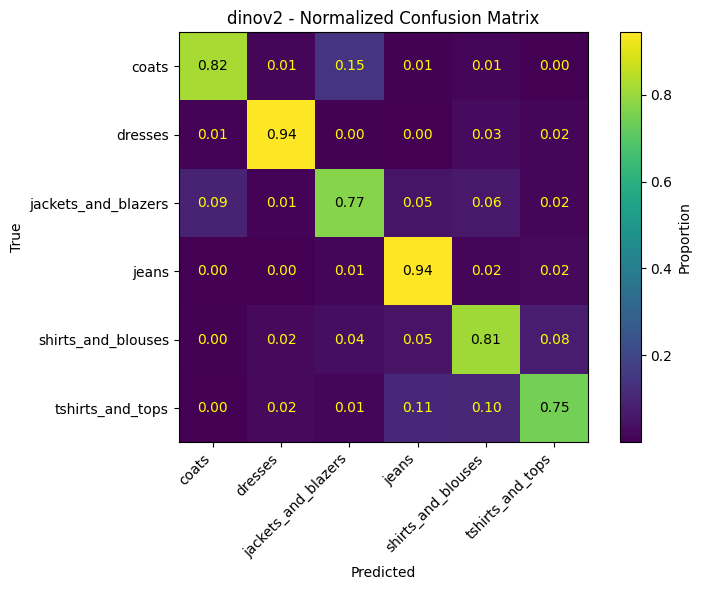

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/kofmanya/HSE-MDS-Kofman-Anna-Diploma/e/HSEM-11
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 5 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 5 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/kofmanya/HSE-MDS-Kofman-Anna-Diploma/e/HSEM-11/metadata


In [15]:
print("Evaluating DINOv2...")
dino_v2_accuracy = evaluate_model(trained_dino, model_name, test_loader)